In [108]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
from keras.models import model_from_json
import numpy as np
import pandas as pd
import time
import tensorflow as tf

In [109]:
# datos: secuencia de observaciones como una lista o matriz 2D NumPy. Necesario.
# n_in: Número de observaciones de retraso como entrada (X). Los valores pueden estar entre [1..len (datos)] Opcional. El valor predeterminado es 1.
# n_out: Número de observaciones como salida (y). Los valores pueden estar entre [0..len (datos) -1]. Opcional. Por defecto es 1.
# dropnan: booleano si se deben soltar o no filas con valores NaN. Opcional. Por defecto es verdadero.


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# observaciones pasadas  (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# tiempos futuros  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [110]:
data = pd.read_excel('../PreparacionDatos/FloraTotal.xlsx' , sheet_name='FloraTotal' ,header=0)

data = data.drop(data.columns[[0]], axis=1) 
#Ordeno de primero el PM10
new_order = [7,1,2,3,4,5,6,0,8,9,10,11,12]
data = data[data.columns[new_order]]

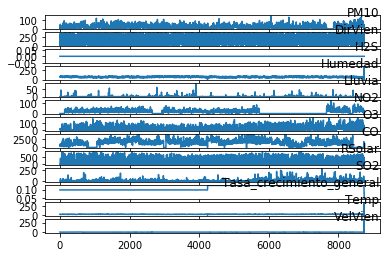

<Figure size 1728x432 with 0 Axes>

In [111]:
# Reprecentacion de los datos.
from matplotlib import pyplot
groups = [0,1,2,3,4,5,6,7,8,9,10,11,12]
i = 1
values = data.values
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.figure(figsize=(24,6))
pyplot.show()

In [112]:
data.describe()

,PM10,DirVien,H2S,Humedad,Lluvia,NO2,O3,CO,RSolar,SO2,Tasa_crecimiento_general,Temp,VelVien
count,8745.000000,8745.000000,8745.0,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000
mean,26.791206,165.549339,0.0,73.829917,0.393544,17.648530,23.094041,1334.647888,152.349769,16.116981,0.111198,24.154810,0.807056
std,20.088073,102.419191,0.0,15.172316,2.767783,14.761252,28.706740,756.503036,219.520964,18.718881,0.013508,4.573652,3.681282
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047700,0.000000,0.000000
25%,10.900000,70.599998,0.0,61.000000,0.000000,0.000000,4.843800,869.296875,0.000000,6.911400,0.097400,21.700001,0.300000
50%,22.700001,157.800003,0.0,76.000000,0.000000,17.919701,9.241700,1292.364258,4.100000,10.784500,0.124300,23.500000,0.600000
75%,38.500000,257.799988,0.0,86.000000,0.000000,26.423599,30.708500,1783.514648,276.700012,17.833300,0.124300,26.500000,1.100000
max,149.699997,360.000000,0.0,339.000000,82.040001,124.501801,181.169403,3703.348877,927.700012,286.557892,0.124300,339.000000,339.000000


In [113]:
values[:,0]

array([ 2.5999999 , 16.29999924,  9.80000019, ...,  0.92900002,
       23.09461594,  0.84630001])

In [114]:
values = data.values

# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.033595   0.489167        0.0   0.206785        0.0        0.0   
2   0.187010   0.413889        0.0   0.225369        0.0        0.0   
3   0.114222   0.400000        0.0   0.233333        0.0        0.0   
4   0.077268   0.547778        0.0   0.240118        0.0        0.0   
5   0.105263   0.081389        0.0   0.254867        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var4(t)  var5(t)  \
1   0.119422   0.105706        0.0    0.020034  ...  0.225369      0.0   
2   0.062049   0.191407        0.0    0.026920  ...  0.233333      0.0   
3   0.045480   0.184672        0.0    0.017923  ...  0.240118      0.0   
4   0.041165   0.227147        0.0    0.023591  ...  0.254867      0.0   
5   0.038357   0.184111        0.0    0.020227  ...  0.258407      0.0   

   var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  var12(t)  \
1      0.0  0.062049  0.191407      0.0  0.026920  0.64

In [115]:
#Dejo la variable objetico en PM10 (T) y y todas (T-1)...................
reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
 
#Dejo la variable objetico en PM10 (T) y las demas en (T-1)...................
#reframed.drop(reframed.columns[[12,14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.033595   0.489167        0.0   0.206785        0.0        0.0   
2   0.187010   0.413889        0.0   0.225369        0.0        0.0   
3   0.114222   0.400000        0.0   0.233333        0.0        0.0   
4   0.077268   0.547778        0.0   0.240118        0.0        0.0   
5   0.105263   0.081389        0.0   0.254867        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.119422   0.105706        0.0    0.020034    0.648825    0.071976   
2   0.062049   0.191407        0.0    0.026920    0.648825    0.069322   
3   0.045480   0.184672        0.0    0.017923    0.648825    0.066962   
4   0.041165   0.227147        0.0    0.023591    0.648825    0.066667   
5   0.038357   0.184111        0.0    0.020227    0.648825    0.064602   

   var13(t-1)   var1(t)  
1    0.009440  0.187010  
2    0.004425  0.114222  
3    0.003835  0.077268  
4    0.000885  0.105263 

In [116]:
values = reframed.values

#Datos de entrenamiento y pruebas:
n_train_hours = 4000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# Datos de entrada y de salida.
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]



#Remodelar la entrada para que sea 3D [muestras, pasos de tiempo, características]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4000, 1, 13) (4000,) (4744, 1, 13) (4744,)


In [117]:
#Diseñando la red neuronal.
model = Sequential()

#Capa de entrada (unidades, 1, 13)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

#Capa de salida.
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.name="LTSM_cali"

#fit(x=None, y=None, batch_size=None, epochs=1, 
#verbose=1, callbacks=None, validation_split=0.0, validation_data=None, 
#shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________


Train on 4000 samples, validate on 4744 samples
Epoch 1/50
 - 1s - loss: 0.2007 - val_loss: 0.1759
Epoch 2/50
 - 0s - loss: 0.1535 - val_loss: 0.1511
Epoch 3/50
 - 0s - loss: 0.1370 - val_loss: 0.1310
Epoch 4/50
 - 0s - loss: 0.1214 - val_loss: 0.1169
Epoch 5/50
 - 0s - loss: 0.1120 - val_loss: 0.1084
Epoch 6/50
 - 0s - loss: 0.1075 - val_loss: 0.1041
Epoch 7/50
 - 0s - loss: 0.1054 - val_loss: 0.1023
Epoch 8/50
 - 0s - loss: 0.1048 - val_loss: 0.1015
Epoch 9/50
 - 0s - loss: 0.1045 - val_loss: 0.1013
Epoch 10/50
 - 0s - loss: 0.1044 - val_loss: 0.1010
Epoch 11/50
 - 0s - loss: 0.1042 - val_loss: 0.1011
Epoch 12/50
 - 0s - loss: 0.1042 - val_loss: 0.1010
Epoch 13/50
 - 0s - loss: 0.1041 - val_loss: 0.1013
Epoch 14/50
 - 0s - loss: 0.1039 - val_loss: 0.1016
Epoch 15/50
 - 0s - loss: 0.1038 - val_loss: 0.1020
Epoch 16/50
 - 0s - loss: 0.1037 - val_loss: 0.1016
Epoch 17/50
 - 0s - loss: 0.1037 - val_loss: 0.1023
Epoch 18/50
 - 0s - loss: 0.1035 - val_loss: 0.1019
Epoch 19/50
 - 0s - loss:

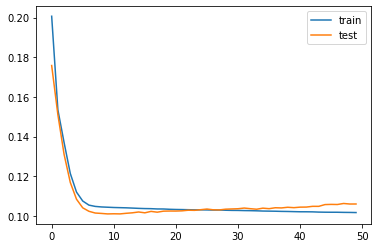

In [118]:

# Ajustado el modelo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Seguimiento al modelo 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [119]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invierto el escalar for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invertir el scaling  actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calcular RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 123.004


In [120]:
# Vuelvo el modelo un archivo .json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    

# Guardar el Modelo
model.save_weights('../Modelamiento/LTSM_Cali.h5')

In [39]:
model

In [40]:
train.shape

(4000, 14)